In [2]:
import pymc3 as pm

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [5]:
df = pd.read_csv('./df.csv')

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,9,10,11,12,13,16,17,20,21,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
df.tail(2)

,zone_id,date,total_demand,t4w_total_demand,t4w_median_demand_same_dow,t4w_median_demand_same_dow_v2,t7d_median_total_demand,holiday_name,t7d_orders,custom_holiday_name,...,total_demand_lag21,total_demand_lag-21,total_demand_new,year,natl_holiday_factor,zone_level_holiday_factor,error,abs_error,pct_error,abs_pct_error
697709,178,2021-05-02,1581.899542,149451.792862,1681.217186,1681.217186,1238.645334,NaN,9945,NaN,...,2055.804675,NaN,1581.899542,2021,NaN,1.0,NaN,NaN,NaN,NaN
697710,603,2021-05-02,359.100738,37315.282715,374.762541,374.762541,325.978169,NaN,2184,NaN,...,383.950529,NaN,359.100738,2021,NaN,1.0,NaN,NaN,NaN,NaN


/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='zone_level_holiday_factor', ylabel='Density'>

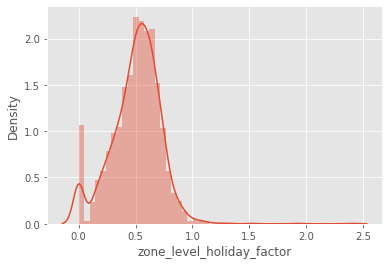

In [15]:
sns.distplot(df.loc[df.holiday_name == 'Easter'].zone_level_holiday_factor)

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='zone_level_holiday_factor', ylabel='Density'>

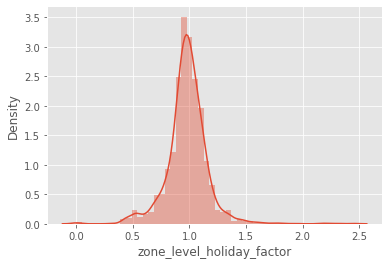

In [160]:
sns.distplot(df.loc[df.holiday_name == 'Super Bowl'].zone_level_holiday_factor)

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='zone_level_holiday_factor', ylabel='Density'>

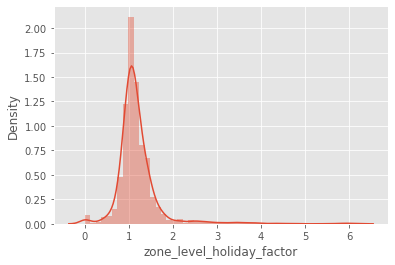

In [209]:
sns.distplot(df.loc[df.holiday_name == 'Labor Day'].zone_level_holiday_factor)

In [210]:
df.loc[df.holiday_name == 'Labor Day'].zone_level_holiday_factor.describe()

count    1621.000000
mean        1.189858
std         0.525896
min         0.000000
25%         0.978657
50%         1.101205
75%         1.282158
max         6.179212
Name: zone_level_holiday_factor, dtype: float64

In [20]:
df.loc[df.holiday_name == 'Easter'].zone_level_holiday_factor.std()**2

0.047023290452113016

In [176]:
df.loc[df.holiday_name == 'Super Bowl'].zone_level_holiday_factor.std()**2

0.03326910706483026

In [275]:
df.loc[df.holiday_name == 'Thanksgiving_lag2'].zone_level_holiday_factor.std()**2

0.07880595045827617

In [274]:
df.loc[df.holiday_name == 'Super Bowl'][['year', 'natl_holiday_factor']].drop_duplicates()

,year,natl_holiday_factor
116367,2018,NaN
295091,2019,0.963613
473815,2020,0.947876
655976,2021,0.947876


In [250]:
df.loc[df.holiday_name == "New Year's Day"].zone_level_holiday_factor.std()**2

0.25433972018405654

In [245]:
df['is_lag_holiday'] = df.holiday_name.str.contains('lag')
df.is_lag_holiday.fillna(False, inplace=True)

high_variance_holidays = df.loc[
    (~df.holiday_name.isna())
    & (~df.is_lag_holiday)
].groupby('holiday_name').zone_level_holiday_factor.std().reset_index(name='std_dev')

In [249]:
high_variance_holidays.sort_values('std_dev').tail(10)

,holiday_name,std_dev
0,Boxing Day,0.432578
2,CA Thanksgiving,0.439288
9,Family Day,0.491249
15,Labour Day,0.501006
19,New Year's Day,0.504321
25,Victoria Day,0.522523
14,Labor Day,0.525896
4,Canada Day (Observed),0.553702
11,Good Friday,1.161028
26,Washington's Birthday,254.079425


In [93]:
df.year.unique()

array([2017, 2018, 2019, 2020, 2021])

In [421]:
within_zone_variation = df.loc[(df.holiday_name == 'Easter')
                               & (df.year < 2021)
                              ].groupby('zone_id').zone_level_holiday_factor.std().reset_index(name='std_dev')
within_zone_variation['var'] = within_zone_variation.std_dev ** 2

within_zone_variation.head(2)

,zone_id,std_dev,var
0,1,0.018135,0.000329
1,13,0.149027,0.022209


In [39]:
within_zone_variation['var'].describe()

count    491.000000
mean       0.030534
std        0.043638
min        0.000138
25%        0.007971
50%        0.018391
75%        0.039200
max        0.609864
Name: var, dtype: float64

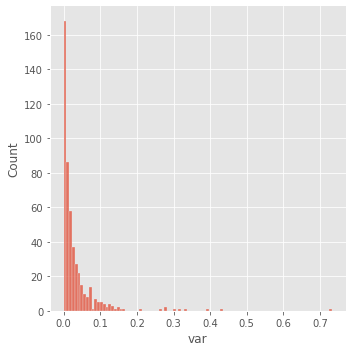

In [377]:
sns.displot(within_zone_variation['var'])

In [163]:
within_zone_variation = df.loc[df.holiday_name == 'Super Bowl'].groupby('zone_id').zone_level_holiday_factor.std().reset_index(name='std_dev')
within_zone_variation['var'] = within_zone_variation.std_dev ** 2

within_zone_variation.head(2)

,zone_id,std_dev,var
0,1,0.034821,0.001213
1,13,0.148293,0.021991


In [164]:
within_zone_variation['var'].describe()

count    491.000000
mean       0.032314
std        0.058918
min        0.000129
25%        0.005333
50%        0.014232
75%        0.035668
max        0.733048
Name: var, dtype: float64

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='var', ylabel='Density'>

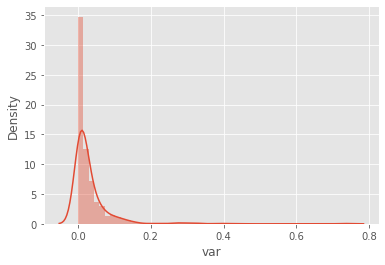

In [165]:
sns.distplot(within_zone_variation['var'])

In [24]:
import scipy.stats as st

In [161]:
s = st.norm

In [ ]:
s.pdf

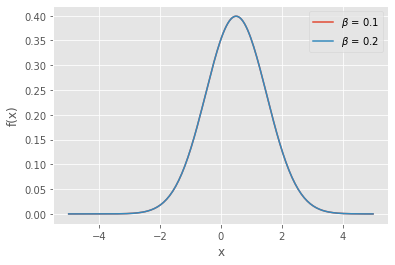

In [167]:
x = np.linspace(-5, 5, 200)
# for b in [0.25, 0.5, 1.0, 2.0]:
for b in [0.1, 0.2]:
    pdf = st.norm.pdf(x, loc=0.5, scale=1)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

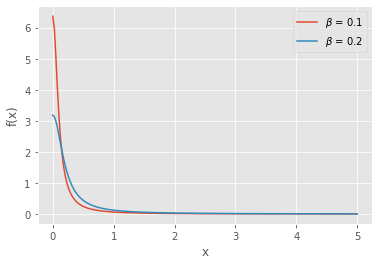

In [37]:
x = np.linspace(0, 5, 200)
# for b in [0.25, 0.5, 1.0, 2.0]:
for b in [0.1, 0.2]:
    pdf = st.halfcauchy.pdf(x, scale=b)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

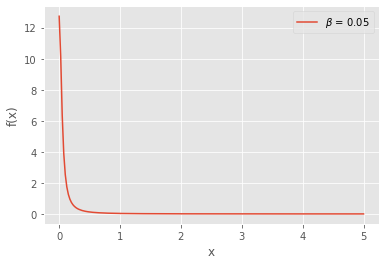

In [41]:
x = np.linspace(0, 5, 200)
# for b in [0.25, 0.5, 1.0, 2.0]:
for b in [0.05]:
    pdf = st.halfcauchy.pdf(x, scale=b)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

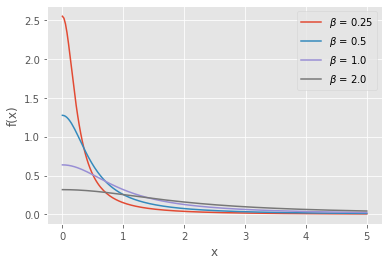

In [38]:
x = np.linspace(0, 5, 200)
for b in [0.25, 0.5, 1.0, 2.0]:
# for b in [0.1, 0.2]:
    pdf = st.halfcauchy.pdf(x, scale=b)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [302]:
dd = df.loc[
    (df.holiday_name == 'Easter') & (df.year < 2021)
#     (df.holiday_name == 'Super Bowl') & (df.year < 2021)
#     (df.holiday_name == 'Labor Day') & (df.year < 2020)
#     (df.holiday_name == "New Year's Day") & (df.year < 2021)
#     (df.holiday_name == 'Thanksgiving_lag2') & (df.year < 2020)
           ]

# [] maybe exclude 2020

zone_list = dd.zone_id.unique()
dd['zone_idx'] = dd.zone_id.apply(lambda x: np.where(zone_list == x)[0][0])

# does this need to be mapped to [0,len(dd.zone_id.unique())-1] ? seems yes
zone_idx = dd.zone_idx.values

<ipython-input-302-ef2c90f74ac0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['zone_idx'] = dd.zone_id.apply(lambda x: np.where(zone_list == x)[0][0])


In [291]:
dd.shape

(1356, 38)

In [292]:
dd.loc[dd.zone_id == 1]

,zone_id,date,total_demand,t4w_total_demand,t4w_median_demand_same_dow,t4w_median_demand_same_dow_v2,t7d_median_total_demand,holiday_name,t7d_orders,custom_holiday_name,...,total_demand_new,year,natl_holiday_factor,zone_level_holiday_factor,error,abs_error,pct_error,abs_pct_error,is_lag_holiday,zone_idx
81510,1,2017-11-25,1702.742905,226041.120144,1981.703931,1981.703931,2007.925724,Thanksgiving_lag2,25132,NaN,...,2043.758660,2017,NaN,0.833143,NaN,NaN,NaN,NaN,True,4
260283,1,2018-11-24,1753.389348,266060.951081,2181.031313,2181.031313,2290.159473,Thanksgiving_lag2,25132,NaN,...,2358.267122,2018,NaN,0.743508,NaN,NaN,NaN,NaN,True,4
442432,1,2019-11-30,2009.490579,248841.447850,2035.175732,2035.175732,2152.915354,Thanksgiving_lag2,25132,NaN,...,2147.608609,2019,0.831549,0.935688,-0.104139,0.104139,-5.379927,5.379927,True,4


In [101]:
with pm.Model() as hierarchical_model:
#     mu_mu = pm.Normal('mu_mu', mu=0.5, sigma=0.05)
    mu_mu = pm.Normal('mu_mu', mu=0.5, sigma=1)
    sigma_mu = pm.HalfCauchy('sigma_mu', beta=0.5)
    
#     mu_sigma = pm.HalfCauchy('mu_sigma', beta=0.1)
#     sigma_sigma = pm.HalfCauchy('sigma_sigma', beta=0.05)
    
    # mean for each zone, normally distributed aroung group mean mu_mu
    mu = pm.Normal('mu', mu=mu_mu, sigma=sigma_mu, shape=len(dd.zone_id.unique()))
    # variation/sigma for each zone, HalfCauchy-distributed (avg within-zone variation) 
    sigma = pm.HalfCauchy('sigma', beta=0.1, shape=len(dd.zone_id.unique()))
    
    # error
    
    # expected value
    
    # data likelihood
    # draw from zone dist
    
    y_like = pm.Normal('y_like', mu=mu[zone_idx], sigma=sigma[zone_idx], observed=dd.zone_level_holiday_factor)
    

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in y_like contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [303]:
with pm.Model() as hierarchical_model:
    # can make mu the nat'l avg for the zone
    mu_mu = pm.Normal('mu_mu', mu=dd.natl_holiday_factor.mean(), sigma=1)
    sigma_mu = pm.HalfCauchy('sigma_mu', beta=0.5)
    
#     mu_sigma = pm.HalfCauchy('mu_sigma', beta=0.1)
#     sigma_sigma = pm.HalfCauchy('sigma_sigma', beta=0.05)
    
    # mean for each zone, normally distributed aroung group mean mu_mu
    mu = pm.Normal('mu', mu=mu_mu, sigma=sigma_mu, shape=len(dd.zone_id.unique()))
    # variation/sigma for each zone, HalfCauchy-distributed (avg within-zone variation) 
    sigma = pm.HalfCauchy('sigma', beta=0.1, shape=len(dd.zone_id.unique()))
    
    # error
    
    # expected value
    
    # data likelihood
    # draw from zone dist
    
    y_like = pm.Normal('y_like', mu=mu[zone_idx], sigma=sigma[zone_idx], observed=dd.zone_level_holiday_factor)
    

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in y_like contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [304]:
with hierarchical_model:
    hierarchical_trace = pm.sample()

<ipython-input-304-febab759f480>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hierarchical_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_like_missing, sigma, mu, sigma_mu, mu_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<ipython-input-103-bea842d6d01d>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hierarchical_trace)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_mu'}>,
        <AxesSubplot:title={'center':'mu_mu'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'y_like_missing'}>,
        <AxesSubplot:title={'center':'y_like_missing'}>],
       [<AxesSubplot:title={'center':'sigma_mu'}>,
        <AxesSubplot:title={'center':'sigma_mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

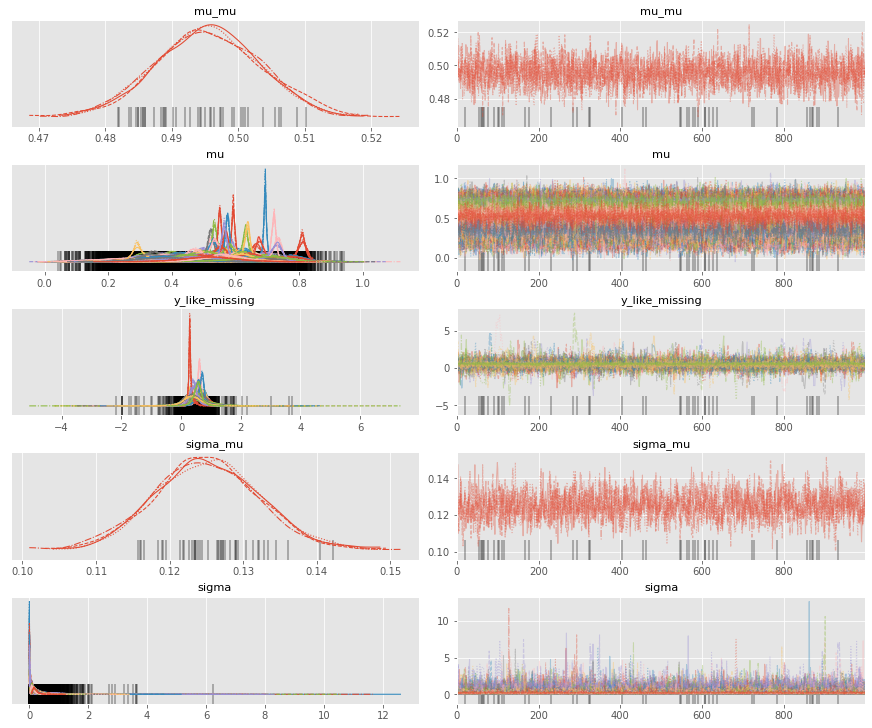

In [103]:
pm.traceplot(hierarchical_trace)

<ipython-input-175-bea842d6d01d>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hierarchical_trace)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_mu'}>,
        <AxesSubplot:title={'center':'mu_mu'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'y_like_missing'}>,
        <AxesSubplot:title={'center':'y_like_missing'}>],
       [<AxesSubplot:title={'center':'sigma_mu'}>,
        <AxesSubplot:title={'center':'sigma_mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

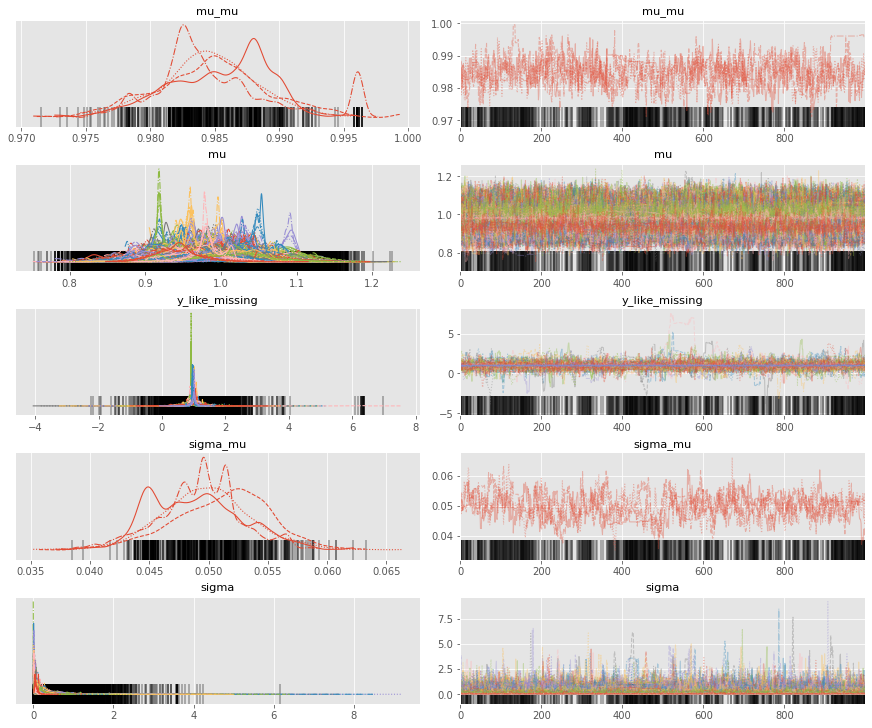

In [175]:
pm.traceplot(hierarchical_trace)

<ipython-input-197-bea842d6d01d>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hierarchical_trace)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_mu'}>,
        <AxesSubplot:title={'center':'mu_mu'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'y_like_missing'}>,
        <AxesSubplot:title={'center':'y_like_missing'}>],
       [<AxesSubplot:title={'center':'sigma_mu'}>,
        <AxesSubplot:title={'center':'sigma_mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

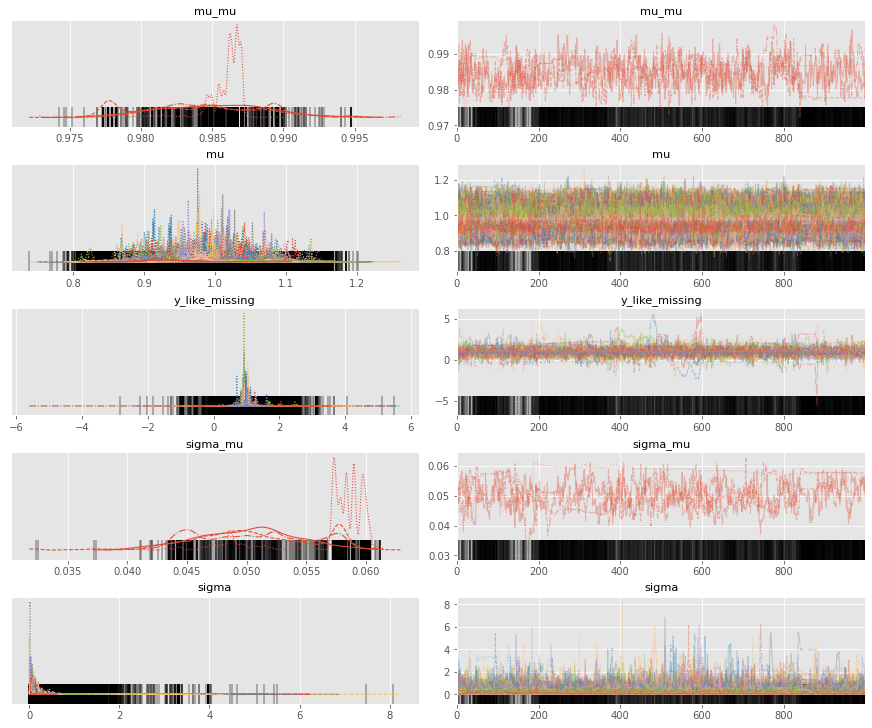

In [197]:
pm.traceplot(hierarchical_trace)

In [67]:
hierarchical_trace['mu'].shape

(4000, 491)

In [75]:
hierarchical_trace['mu'].shape

(4000, 491)

In [74]:
hierarchical_trace['mu']

array([[0.31344046, 0.44019773, 0.47683574, ..., 0.77623633, 0.62710173,
        0.51711677],
       [0.70872079, 0.4251618 , 0.55469253, ..., 0.63286389, 0.5954941 ,
        0.56497231],
       [0.66546887, 0.39467603, 0.5337304 , ..., 0.73641087, 0.60846766,
        0.48160787],
       ...,
       [0.30705489, 0.36521131, 0.50554595, ..., 0.67960578, 0.54630467,
        0.55893768],
       [0.29097392, 0.39448571, 0.53151585, ..., 0.69911945, 0.47097007,
        0.54397055],
       [0.56018689, 0.39544995, 0.63069765, ..., 0.77558723, 0.34577156,
        0.46741167]])

In [80]:
## just accessed the z_th of 4000 traces
hierarchical_trace['mu'][z]

array([0.54468162, 0.37486096, 0.47621376, 0.6124017 , 0.41576822,
       0.44291413, 0.50432104, 0.65905777, 0.56632284, 0.60135845,
       0.71119185, 0.42252329, 0.47490416, 0.48090378, 0.50073252,
       0.43680844, 0.4191377 , 0.44942057, 0.41984944, 0.55339833,
       0.51402489, 0.44765164, 0.56869207, 0.48320349, 0.58919705,
       0.28311111, 0.43561512, 0.73246742, 0.67118101, 0.45376336,
       0.54314248, 0.40642693, 0.45773629, 0.36560744, 0.47474255,
       0.46747256, 0.47412104, 0.41515326, 0.54851635, 0.30712204,
       0.58353565, 0.56077363, 0.49745334, 0.59853488, 0.48652474,
       0.49227794, 0.53125623, 0.49034747, 0.4331926 , 0.82917383,
       0.48815573, 0.54489236, 0.37903564, 0.53431579, 0.53688067,
       0.27933413, 0.4419262 , 0.56349126, 0.56164085, 0.57105386,
       0.33430982, 0.49294488, 0.39573579, 0.55367665, 0.68240173,
       0.36774251, 0.45321359, 0.57251424, 0.52416595, 0.63332474,
       0.4086763 , 0.42129998, 0.52807652, 0.22658574, 0.46238

In [119]:
# z_th entry from all 4000 traces
hierarchical_trace['mu'][:,z]

array([0.79326313, 0.79473136, 0.82605117, ..., 0.81561638, 0.81499246,
       0.80587846])

In [434]:
hierarchical_trace['mu_mu'].shape

(4000,)

In [435]:
hierarchical_trace['mu'].shape

(4000, 491)

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

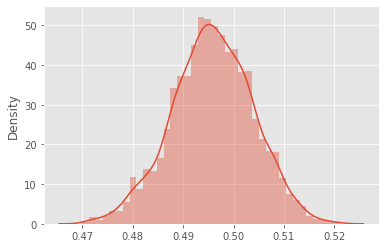

In [436]:
sns.distplot(hierarchical_trace['mu_mu'])

##### Case Studies

In [378]:
z = dd.loc[dd.zone_id == 1].zone_idx.unique()[0]
z

49

In [381]:
dd.loc[(dd.zone_id == 1)
       & (dd.holiday_name == 'Easter')].zone_level_holiday_factor

143912    0.822235
333322    0.795012
508304    0.829380
Name: zone_level_holiday_factor, dtype: float64

Text(0.5, 1.0, 'SF - Actual Easter Effect')

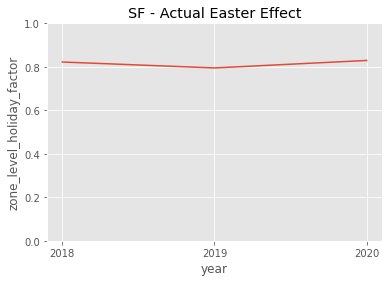

In [385]:
ax = sns.lineplot(x='year', y='zone_level_holiday_factor',
             data = dd.loc[
                 (dd.zone_id == 1)
                 & (dd.holiday_name == 'Easter')
             ]
            )

xticks = ax.set_xticks([2018, 2019, 2020])
ax.set_ylim(0,1)
ax.set_title('SF - Actual Easter Effect')

In [386]:
df.loc[(df.zone_id == 1)
       & (df.holiday_name == 'Easter')].zone_level_holiday_factor

143912    0.822235
333322    0.795012
508304    0.829380
683708    0.895054
Name: zone_level_holiday_factor, dtype: float64

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SF - U_z posterior distribution')

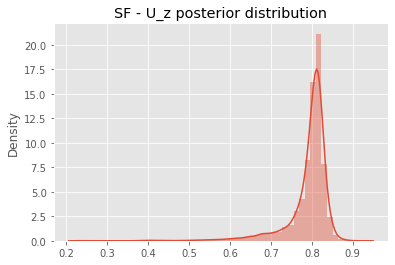

In [387]:
ax = sns.distplot(hierarchical_trace['mu'][:,z])
ax.set_title('SF - U_z posterior distribution')

In [388]:
hierarchical_trace['mu'][:,z].mean()

0.7913337052951342

In [125]:
z = dd.loc[dd.zone_id == 33].zone_idx.unique()[0]
z

231

In [126]:
dd.loc[(dd.zone_id == 33)
       & (dd.holiday_name == 'Easter')].zone_level_holiday_factor

144094    0.827801
333242    0.802089
508466    0.805509
Name: zone_level_holiday_factor, dtype: float64

In [127]:
df.loc[(df.zone_id == 33)
       & (df.holiday_name == 'Easter')].zone_level_holiday_factor

144094    0.827801
333242    0.802089
508466    0.805509
683771    0.817440
Name: zone_level_holiday_factor, dtype: float64

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

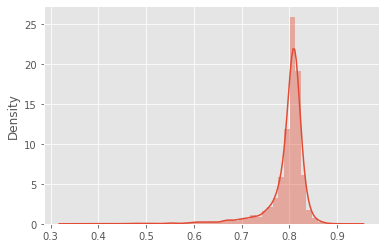

In [128]:
sns.distplot(hierarchical_trace['mu'][:,z])

In [129]:
hierarchical_trace['mu'][:,z].mean()

0.7948282137779118

In [85]:
within_zone_variation.head(2)

,zone_id,std_dev,var
0,1,0.042424,0.001800
1,13,0.130083,0.016922


In [124]:
within_zone_variation.sort_values('std_dev').head(5)

,zone_id,std_dev,var
8,33,0.011744,0.000138
430,841,0.011848,0.000140
214,431,0.017159,0.000294
226,445,0.019570,0.000383
4,18,0.019887,0.000395


In [422]:
within_zone_variation.sort_values('std_dev').tail(10)

,zone_id,std_dev,var
453,949,0.407482,0.166042
431,842,0.409201,0.167445
270,505,0.427338,0.182618
486,1447,0.435773,0.189898
378,704,0.469273,0.220218
420,820,0.500153,0.250153
469,988,0.576781,0.332676
108,267,0.596402,0.355695
435,854,0.742351,0.551085
436,856,0.886123,0.785213


In [423]:
z_id = 988

In [424]:
z = dd.loc[dd.zone_id == z_id].zone_idx.unique()[0]
z

399

In [425]:
dd.loc[(dd.zone_id == z_id)
       & (dd.holiday_name == 'Easter')].zone_level_holiday_factor

144262         NaN
332989    0.500509
508246    1.316201
Name: zone_level_holiday_factor, dtype: float64

In [431]:
dd.loc[(dd.zone_id == z_id)
       & (dd.holiday_name == 'Easter')].zone_level_holiday_factor.mean()

0.9083550973800751

In [427]:
df.loc[(df.zone_id == z_id)
       & (df.holiday_name == 'Easter')][['zone_id', 'year', 'zone_level_holiday_factor', 'total_demand', 'total_demand_new']]

,zone_id,year,zone_level_holiday_factor,total_demand,total_demand_new
144262,988,2018,NaN,0.000000,0.000000
332989,988,2019,0.500509,433.731239,866.579623
508246,988,2020,1.316201,9622.190409,7310.579344
683519,988,2021,0.572155,1885.265290,3295.025444


Text(0.5, 1.0, 'Rochester, NY - Actual Easter Effect')

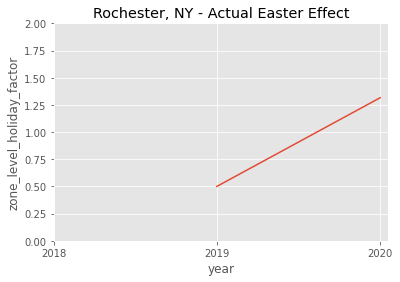

In [432]:
ax = sns.lineplot(x='year', y='zone_level_holiday_factor',
             data = dd.loc[
                 (dd.zone_id == z_id)
                 & (dd.holiday_name == 'Easter')
             ]
            )

xticks = ax.set_xticks([2018, 2019, 2020])
ax.set_ylim(0,2)
ax.set_title('Rochester, NY - Actual Easter Effect')

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rochester, NY - U_z posterior distribution')

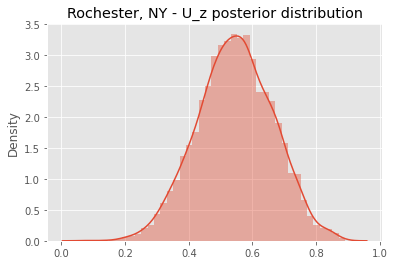

In [433]:
ax = sns.distplot(hierarchical_trace['mu'][:,z])
ax.set_title('Rochester, NY - U_z posterior distribution')

In [415]:
hierarchical_trace['mu'][:,z].mean()

0.5936687230821891

In [113]:
z = dd.loc[dd.zone_id == 854].zone_idx.unique()[0]
z

384

In [114]:
dd.loc[(dd.zone_id == 854)
       & (dd.holiday_name == 'Easter')].zone_level_holiday_factor

144247    1.923392
333275    0.530750
508575    0.781352
Name: zone_level_holiday_factor, dtype: float64

In [115]:
df.loc[(df.zone_id == 854)
       & (df.holiday_name == 'Easter')].zone_level_holiday_factor

144247    1.923392
333275    0.530750
508575    0.781352
683789    0.665824
Name: zone_level_holiday_factor, dtype: float64

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

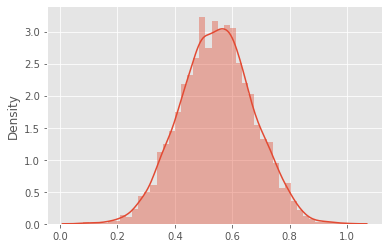

In [116]:
sns.distplot(hierarchical_trace['mu'][:,z])

##### WFV

In [279]:
df.tail(2)

,zone_id,date,total_demand,t4w_total_demand,t4w_median_demand_same_dow,t4w_median_demand_same_dow_v2,t7d_median_total_demand,holiday_name,t7d_orders,custom_holiday_name,...,total_demand_lag-21,total_demand_new,year,natl_holiday_factor,zone_level_holiday_factor,error,abs_error,pct_error,abs_pct_error,is_lag_holiday
697709,178,2021-05-02,1581.899542,149451.792862,1681.217186,1681.217186,1238.645334,NaN,9945,NaN,...,NaN,1581.899542,2021,NaN,1.0,NaN,NaN,NaN,NaN,False
697710,603,2021-05-02,359.100738,37315.282715,374.762541,374.762541,325.978169,NaN,2184,NaN,...,NaN,359.100738,2021,NaN,1.0,NaN,NaN,NaN,NaN,False


In [305]:
zone_ids, zone_factor_estimates = [], []

for z_id in dd.zone_id.unique():
    z_idx = dd.loc[dd.zone_id == z_id].zone_idx.unique()[0]
    zone_factor_estimate = hierarchical_trace['mu'][:,z_idx].mean()
    
    zone_ids.append(z_id)
    zone_factor_estimates.append(zone_factor_estimate)
    
res = pd.DataFrame({'zone_id': zone_ids,
                    'zone_factor_estimate': zone_factor_estimates})

In [281]:
res.head(2)

,zone_id,zone_factor_estimate
0,360,0.834596
1,274,0.833192


In [132]:
res.head(2)

,zone_id,zone_factor_estimate
0,770,0.327220
1,159,0.504085


In [225]:
res.head(2)

,zone_id,zone_factor_estimate
0,236,1.079012
1,145,1.154907


In [200]:
res.head(2)

,zone_id,zone_factor_estimate
0,770,1.007378
1,159,0.979043


In [136]:
df.head(2)

,zone_id,date,total_demand,t4w_total_demand,t4w_median_demand_same_dow,t4w_median_demand_same_dow_v2,t7d_median_total_demand,holiday_name,t7d_orders,custom_holiday_name,...,total_demand_lag21,total_demand_lag-21,total_demand_new,year,natl_holiday_factor,zone_level_holiday_factor,error,abs_error,pct_error,abs_pct_error
0,770,2017-06-12,0.0,0.0,0.0,0.0,0.0,NaN,6021,NaN,...,0.0,0.000000,0.0,2017,NaN,NaN,NaN,NaN,NaN,NaN
1,159,2017-06-12,0.0,0.0,0.0,0.0,0.0,NaN,8057,NaN,...,0.0,70.883566,0.0,2017,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
df.loc[(df.zone_id == 159)& (df.holiday_name == 'Super Bowl')][['year', 'zone_level_holiday_factor', 'natl_holiday_factor', 'error', 'abs_error', 'pct_error', 'abs_pct_error']]

,year,zone_level_holiday_factor,natl_holiday_factor,error,abs_error,pct_error,abs_pct_error
116653,2018,0.978661,NaN,NaN,NaN,NaN,NaN
295371,2019,1.018908,0.963613,-0.055295,0.055295,-2.738863,2.738863
474164,2020,0.916495,0.947876,0.031380,0.031380,1.637379,1.637379
656109,2021,1.013272,0.947876,-0.065397,0.065397,-3.248282,3.248282


In [306]:
fin = df.loc[
             (df.year == 2021) & (df.holiday_name == 'Easter')
#              (df.year == 2021) & (df.holiday_name == 'Super Bowl')
#              (df.year == 2020) & (df.holiday_name == 'Labor Day')
#              (df.year == 2021) & (df.holiday_name == "New Year's Day")
#              (df.year == 2020) & (df.holiday_name == 'Thanksgiving_lag2')
            ].merge(res, how='left', on='zone_id')

In [307]:
fin.shape

(491, 38)

In [203]:
fin.loc[(fin.zone_id.isin([159, 856, 1, 13, 861, 972, 979, 18]))& (fin.holiday_name == 'Super Bowl')][['year', 'holiday_name', 'zone_id', 'zone_level_holiday_factor', 'zone_factor_estimate', 'natl_holiday_factor', 'error', 'abs_error', 'pct_error', 'abs_pct_error']]

,year,holiday_name,zone_id,zone_level_holiday_factor,zone_factor_estimate,natl_holiday_factor,error,abs_error,pct_error,abs_pct_error
21,2021,Super Bowl,1,0.949155,0.957444,0.947876,-0.001279,0.001279,-0.065631,0.065631
133,2021,Super Bowl,159,1.013272,0.979043,0.947876,-0.065397,0.065397,-3.248282,3.248282
221,2021,Super Bowl,972,0.961506,0.945722,0.947876,-0.013631,0.013631,-0.694907,0.694907
260,2021,Super Bowl,861,0.705919,0.987670,0.947876,0.241957,0.241957,14.183383,14.183383
267,2021,Super Bowl,979,0.959392,0.966287,0.947876,-0.011517,0.011517,-0.587762,0.587762
345,2021,Super Bowl,18,0.734959,0.978375,0.947876,0.212916,0.212916,12.272127,12.272127
380,2021,Super Bowl,13,0.678034,0.956140,0.947876,0.269842,0.269842,16.080825,16.080825
428,2021,Super Bowl,856,1.359933,1.018080,0.947876,-0.412057,0.412057,-17.460543,17.460543


In [308]:
dd.year.unique()

array([2018, 2019, 2020])

In [309]:
naive_zone_factor_estimates = dd.groupby('zone_id').zone_level_holiday_factor.mean().reset_index(name='naive_zone_factor_estimate')
naive_zone_factor_estimates.head(2)

fin = fin.merge(naive_zone_factor_estimates, how='left', on='zone_id')

In [316]:
fin.year.unique().item() - 1

2020

In [323]:
def get_base_yr(x):
    if x == 2021:
        return 2019
    return x - 1

In [332]:
naive_zone_factor_estimates2 = dd.loc[
#     dd.year == fin.year.unique().item() - 1
    dd.year == get_base_yr(fin.year.unique().item())
].groupby('zone_id').zone_level_holiday_factor.mean().reset_index(name='naive_zone_factor_estimate2')
naive_zone_factor_estimates.head(2)

fin = fin.merge(naive_zone_factor_estimates2, how='left', on='zone_id')

In [333]:
fin['error_old'] = fin.natl_holiday_factor - fin.zone_level_holiday_factor
fin['abs_error_old'] = fin.error.abs()

fin['error_naive'] = fin.naive_zone_factor_estimate - fin.zone_level_holiday_factor
fin['abs_error_naive'] = fin.error_naive.abs()

fin['error_naive2'] = fin.naive_zone_factor_estimate2 - fin.zone_level_holiday_factor
fin['abs_error_naive2'] = fin.error_naive2.abs()

fin['error_new'] = fin.zone_factor_estimate - fin.zone_level_holiday_factor
fin['abs_error_new'] = fin.error_new.abs()

In [315]:
fin.year.unique(), fin.holiday_name.unique()

(array([2021]), array(['Easter'], dtype=object))

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Easter 2021 - Error Distributions Comparison')

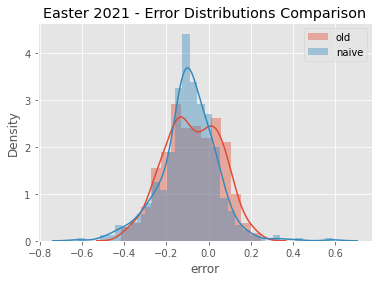

In [336]:
# Easter

ax = sns.distplot(fin.error_old, label='old')
# sns.distplot(fin.error_new, label='new', ax=ax)
sns.distplot(fin.error_naive, label='naive', ax=ax)

ax.legend(loc='best')
ax.set_xlabel('error')

ax.set_title('Easter 2021 - Error Distributions Comparison')

In [337]:
# Easter
fin[['abs_error_old', 'abs_error_naive']].describe()

,abs_error_old,abs_error_naive
count,491.000000,491.000000
mean,0.123833,0.126963
std,0.089459,0.104023
min,0.000408,0.000050
25%,0.052236,0.048811
50%,0.109887,0.103540
75%,0.178854,0.165400
max,0.414915,0.622735


In [338]:
fin['naive_diff'] = fin.abs_error_old - fin.abs_error_naive

In [339]:
fin.sort_values('naive_diff').tail(10)[['zone_id', 'abs_error_old', 'abs_error_naive', 'naive_diff']]

,zone_id,abs_error_old,abs_error_naive,naive_diff
233,103,0.274139,0.014056,0.260084
348,1002,0.273020,0.002438,0.270582
464,857,0.324805,0.041927,0.282878
299,33,0.319862,0.005640,0.314222
371,1001,0.354660,0.039535,0.315125
236,1,0.397476,0.079512,0.317965
392,983,0.351570,0.028774,0.322795
240,979,0.354488,0.006999,0.347490
242,652,0.396939,0.037857,0.359081
195,972,0.414915,0.003910,0.411005


<AxesSubplot:xlabel='year', ylabel='zone_level_holiday_factor'>

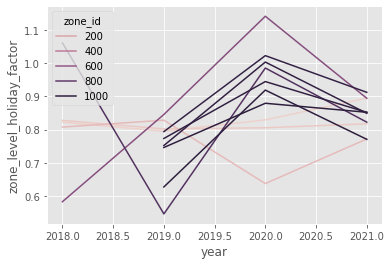

In [340]:
d = df.loc[(df.zone_id.isin(fin.sort_values('naive_diff').tail(10).zone_id))
       & (df.holiday_name == 'Easter')]

sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, hue='zone_id')

<AxesSubplot:xlabel='year', ylabel='zone_level_holiday_factor'>

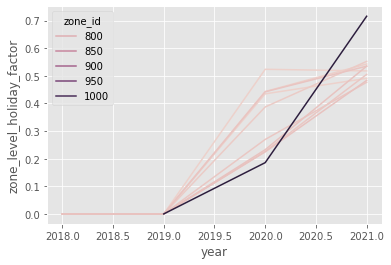

In [341]:
d = df.loc[(df.zone_id.isin(fin.sort_values('naive_diff').head(10).zone_id))
       & (df.holiday_name == 'Easter')]

sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, hue='zone_id')

In [352]:
fin.naive_diff.describe()

count    491.000000
mean      -0.003130
std        0.133699
min       -0.422251
25%       -0.079929
50%        0.003163
75%        0.084477
max        0.411005
Name: naive_diff, dtype: float64

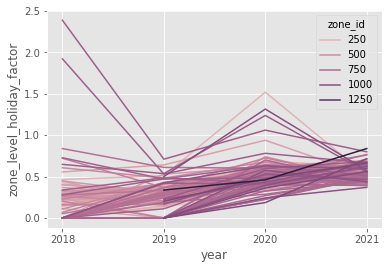

In [364]:
d = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff < fin.naive_diff.quantile(.25)].zone_id))
       & (df.holiday_name == 'Easter')]

ax = sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, hue='zone_id')
xticks = ax.set_xticks([2018, 2019, 2020, 2021])

Text(0.5, 1.0, 'Worst 15% of Zones under Naive Estimate')

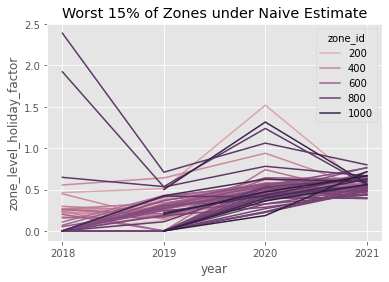

In [367]:
d = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff < fin.naive_diff.quantile(.15)].zone_id))
       & (df.holiday_name == 'Easter')]

ax = sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, hue='zone_id')
xticks = ax.set_xticks([2018, 2019, 2020, 2021])
ax.set_title('Worst 15% of Zones under Naive Estimate')

Text(0.5, 1.0, 'Best 15% of Zones under Naive Estimate')

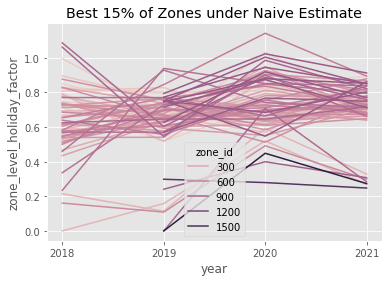

In [368]:
d = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff > fin.naive_diff.quantile(.85)].zone_id))
       & (df.holiday_name == 'Easter')]

ax = sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, hue='zone_id')
xticks = ax.set_xticks([2018, 2019, 2020, 2021])
ax.set_title('Best 15% of Zones under Naive Estimate')

<ipython-input-373-a224f9979b63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['type'] = 'all'
<ipython-input-373-a224f9979b63>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_best['type'] = 'best'
<ipython-input-373-a224f9979b63>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

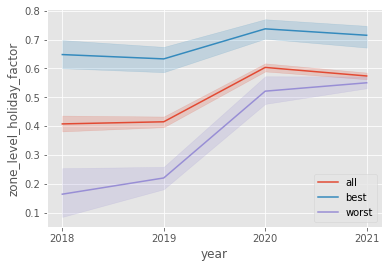

In [373]:
d = df.loc[(df.holiday_name == 'Easter')]
d['type'] = 'all'

d_best = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff > fin.naive_diff.quantile(.85)].zone_id))
       & (df.holiday_name == 'Easter')]
d_best['type'] = 'best'

d_worst = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff < fin.naive_diff.quantile(.15)].zone_id))
       & (df.holiday_name == 'Easter')]
d_worst['type'] = 'worst'

ax = sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, label='all')
sns.lineplot(x='year', y='zone_level_holiday_factor', data=d_best, label='best')
sns.lineplot(x='year', y='zone_level_holiday_factor', data=d_worst, label='worst')
xticks = ax.set_xticks([2018, 2019, 2020, 2021])

<ipython-input-375-80b56344eebb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['type'] = 'all'
<ipython-input-375-80b56344eebb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_best['type'] = 'best'
<ipython-input-375-80b56344eebb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

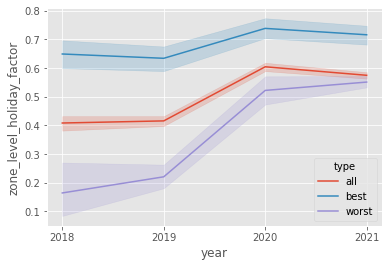

In [375]:
d = df.loc[(df.holiday_name == 'Easter')]
d['type'] = 'all'

d_best = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff > fin.naive_diff.quantile(.85)].zone_id))
       & (df.holiday_name == 'Easter')]
d_best['type'] = 'best'

d_worst = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff < fin.naive_diff.quantile(.15)].zone_id))
       & (df.holiday_name == 'Easter')]
d_worst['type'] = 'worst'

all_d = pd.concat([d, d_best, d_worst])

ax = sns.lineplot(x='year', y='zone_level_holiday_factor', data=all_d, hue='type')
# sns.lineplot(x='year', y='zone_level_holiday_factor', data=d_best, label='best')
# sns.lineplot(x='year', y='zone_level_holiday_factor', data=d_worst, label='worst')
xticks = ax.set_xticks([2018, 2019, 2020, 2021])

In [359]:
xx = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff > fin.naive_diff.quantile(.75)].zone_id))
       & (df.holiday_name == 'Easter')].groupby('zone_id').zone_level_holiday_factor.std().reset_index(name='std_dev')

xx.head(2)

,zone_id,std_dev
0,1,0.042424
1,13,0.130083


In [371]:
xx = df.loc[
    (df.zone_id.isin(fin.loc[fin.naive_diff > fin.naive_diff.quantile(.85)].zone_id))
    & (df.holiday_name == 'Easter')
    & (df.year < 2021)
           ].groupby('zone_id').zone_level_holiday_factor.std().reset_index(name='std_dev')

xx.head(2)

,zone_id,std_dev
0,1,0.018135
1,14,0.114352


In [372]:
# best 15%
xx.std_dev.describe()

count    74.000000
mean      0.130055
std       0.092794
min       0.004915
25%       0.073177
50%       0.107536
75%       0.185514
max       0.500153
Name: std_dev, dtype: float64

In [370]:
# worst 15%
xx.std_dev.describe()

count    74.000000
mean      0.247338
std       0.130679
min       0.063423
25%       0.184796
50%       0.227205
75%       0.270296
max       0.886123
Name: std_dev, dtype: float64

<AxesSubplot:xlabel='year', ylabel='zone_level_holiday_factor'>

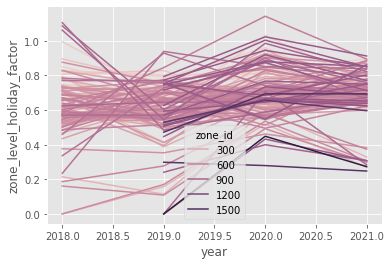

In [355]:
d = df.loc[(df.zone_id.isin(fin.loc[fin.naive_diff > fin.naive_diff.quantile(.75)].zone_id))
       & (df.holiday_name == 'Easter')]

sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, hue='zone_id')

<AxesSubplot:xlabel='year', ylabel='zone_level_holiday_factor'>

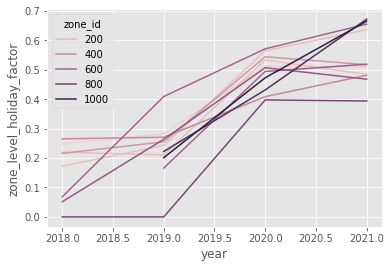

In [351]:
d = df.loc[(df.zone_id.isin(fin.sort_values('naive_diff').reset_index().loc[50:60,:].zone_id))
       & (df.holiday_name == 'Easter')]

sns.lineplot(x='year', y='zone_level_holiday_factor', data=d, hue='zone_id')

In [342]:
d.loc[d.year == 2019]

,zone_id,date,total_demand,t4w_total_demand,t4w_median_demand_same_dow,t4w_median_demand_same_dow_v2,t7d_median_total_demand,holiday_name,t7d_orders,custom_holiday_name,...,total_demand_lag-21,total_demand_new,year,natl_holiday_factor,zone_level_holiday_factor,error,abs_error,pct_error,abs_pct_error,is_lag_holiday
332908,1029,2019-04-21,0.0,7281.556258,69.158303,69.158303,68.088499,Easter,9272,Easter,...,46.992831,66.794871,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
332990,758,2019-04-21,0.0,4139.823186,45.244554,45.244554,33.443541,Easter,5641,Easter,...,33.414323,39.134427,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333123,773,2019-04-21,0.0,3447.276083,34.282303,34.282303,28.212011,Easter,3002,Easter,...,10.858324,21.384528,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333147,765,2019-04-21,0.0,8596.886756,109.144401,109.144401,62.308067,Easter,7135,Easter,...,82.960780,83.933360,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333170,769,2019-04-21,0.0,3997.146400,46.316627,46.316627,29.570961,Easter,4100,Easter,...,44.894978,39.197800,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333213,774,2019-04-21,0.0,13027.030898,152.090516,152.090516,117.264987,Easter,8354,Easter,...,96.815189,123.176583,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333246,761,2019-04-21,0.0,2816.343150,36.642327,36.642327,21.398878,Easter,2837,Easter,...,29.603527,34.047830,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333313,776,2019-04-21,0.0,3549.439550,37.278740,37.278740,29.774919,Easter,4853,Easter,...,36.447060,34.582531,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333348,757,2019-04-21,0.0,2357.699392,26.266509,26.266509,21.505992,Easter,3784,Easter,...,30.135714,26.065378,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False
333388,770,2019-04-21,0.0,12638.887551,148.524371,148.524371,87.890012,Easter,6021,Easter,...,117.980449,131.610274,2019,0.489229,0.0,0.489229,0.489229,48.922915,48.922915,False


/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

Text(0.5, 1.0, 'Easter 2021 - Error Distributions Comparison')

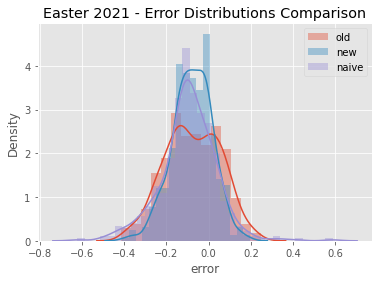

In [439]:
# Easter

ax = sns.distplot(fin.error_old, label='old')
sns.distplot(fin.error_new, label='new', ax=ax)
sns.distplot(fin.error_naive, label='naive', ax=ax)

ax.legend(loc='best')
ax.set_xlabel('error')

ax.set_title('Easter 2021 - Error Distributions Comparison')

In [437]:
# Easter
fin[['abs_error_old', 'abs_error_naive', 'abs_error_new']].describe()

,abs_error_old,abs_error_naive,abs_error_new
count,491.000000,491.000000,491.000000
mean,0.123833,0.126963,0.097502
std,0.089459,0.104023,0.075113
min,0.000408,0.000050,0.000282
25%,0.052236,0.048811,0.036919
50%,0.109887,0.103540,0.083072
75%,0.178854,0.165400,0.142341
max,0.414915,0.622735,0.408966


/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

Text(0.5, 0, 'error')

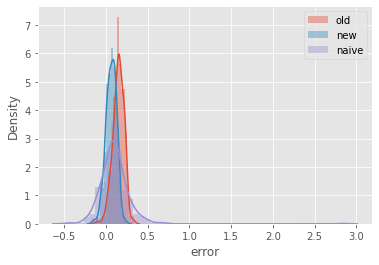

In [299]:
# Txsgiving lag2

ax = sns.distplot(fin.error_old, label='old')
sns.distplot(fin.error_new, label='new', ax=ax)
sns.distplot(fin.error_naive, label='naive', ax=ax)

ax.legend(loc='best')
ax.set_xlabel('error')

In [300]:
# Txsgiving lag2
fin[['abs_error_old', 'abs_error_naive', 'abs_error_new']].describe()

,abs_error_old,abs_error_naive,abs_error_new
count,452.000000,452.000000,452.000000
mean,0.149844,0.143045,0.073804
std,0.063599,0.169385,0.048551
min,0.000275,0.000231,0.000175
25%,0.106818,0.059354,0.034263
50%,0.151064,0.112763,0.069190
75%,0.196771,0.182014,0.108962
max,0.338553,2.836837,0.245870


In [ ]:
# [X] naive zone avg
# [] try no 2020
# [/] other holidays
# store hr feats

In [ ]:
# for seasonality: if want to do bayesian, would have to code up HW or FB prophet or such
    # kind of involved but could be good to do that